## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import qmc
import random
import matplotlib
import matplotlib.lines as mlines


# Set global parameters
matplotlib.rcParams.update({
    'font.size': 12,  # Adjust font size
    'figure.dpi': 300  # Set high resolution for the plot
})


seed = 42
random.seed(seed)
np.random.seed(seed)

## Basic Fully-Connected Network

In [2]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        activation = nn.Tanh

        # Input layer
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())

        # Hidden layers
        hidden_layers = [nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)]
        self.fch = nn.Sequential(*hidden_layers)

        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        for hidden_layer in self.fch:
            x = hidden_layer(x)
        x = self.fce(x)
        return x

# Example usage
N_INPUT = 3
N_OUTPUT = 2
N_HIDDEN = 20
N_LAYERS = 5

pinn = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

## Training

In [3]:
def init_xavier(model, retrain_seed=42):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)
init_xavier(pinn, seed)

In [3]:
# Constants
X, Y, T = 1.1, 0.2, 0.5  # domain limits
p_in, p_out = 1.0, 0.0 # Pressure in, pressure out

N_x = 55
N_y = 10
N_t = 50

resolution = max(X/N_x, Y/N_y)
epsilon = (1.01/2)*resolution

# Physics collocation points
t_values = torch.linspace(0, T, N_t).view(-1, 1)
x_values = torch.linspace(0, X, N_x).view(-1, 1)
y_values = torch.linspace(0, Y, N_y).view(-1, 1)

t_physics, x_physics, y_physics = torch.meshgrid(t_values[:, 0], x_values[:, 0], y_values[:, 0], indexing='ij')

# Flatten the grid to pass through the network
t_physics = t_physics.reshape(-1, 1).requires_grad_(True)
x_physics = x_physics.reshape(-1, 1).requires_grad_(True)
y_physics = y_physics.reshape(-1, 1).requires_grad_(True)

#Initial condition points
x_IC, y_IC = torch.meshgrid(x_values[:, 0], y_values[:, 0], indexing='ij')

x_IC = x_IC.reshape(-1, 1)
y_IC = y_IC.reshape(-1, 1)
t_IC = torch.zeros_like(x_IC)

# Linear drop from pin to pout before x = x_in, then continue linearly
r_in = 0.2
gradient = (p_out - p_in)/r_in

phi_IC = x_IC - r_in
p_IC = gradient*phi_IC

# Inlet boundary condition points
t_BC_inlet, y_BC_inlet = torch.meshgrid(t_values[:, 0], y_values[:, 0], indexing='ij')

t_BC_inlet = t_BC_inlet.reshape(-1, 1)
y_BC_inlet = y_BC_inlet.reshape(-1, 1)
x_BC_inlet = torch.zeros_like(t_BC_inlet)

# Wall boundary condition points
y_values = torch.linspace(0, Y, 2).view(-1, 1)

t_BC_walls, x_BC_walls, y_BC_walls = torch.meshgrid(t_values[:, 0], x_values[:, 0], y_values[:, 0], indexing='ij')

t_BC_walls = t_BC_walls.reshape(-1, 1)
x_BC_walls = x_BC_walls.reshape(-1, 1)
y_BC_walls = y_BC_walls.reshape(-1, 1).requires_grad_(True)

In [5]:
def D(phi, epsilon):
  output = torch.where(torch.abs(phi) < epsilon, 1., 0.)
  return output

# Initialize a dictionary to store the individual loss components
loss_history = {
    'total_loss': [], 
    'p_ic_loss': [], 
    'phi_ic_loss': [],
    'inlet_bc_loss': [], 
    'walls_bc_loss': [],
    'front_bc_loss': [], 
    'laplace_loss': [], 
    'level_set_loss': [], 
    'eikonal_loss': []
    }

for iteration in range(25000):
    optimiser.zero_grad()

    losses = []

    # Compute phi IC loss
    combined_input = torch.cat([t_IC, x_IC, y_IC], dim=1)
    p, phi = pinn(combined_input).split(1, dim=1)

    p_ic_loss = torch.mean((p - p_IC)**2)
    phi_ic_loss = torch.mean((phi - phi_IC)**2)

    # Compute inlet boundary loss
    combined_input = torch.cat([t_BC_inlet, x_BC_inlet, y_BC_inlet], dim=1)
    p, _ = pinn(combined_input).split(1, dim=1)

    inlet_bc_loss = torch.mean((p - p_in)**2)

    # Compute wall boundary loss
    combined_input = torch.cat([t_BC_walls, x_BC_walls, y_BC_walls], dim=1)
    p, _ = pinn(combined_input).split(1, dim=1)

    p_y = torch.autograd.grad(p, y_BC_walls, torch.ones_like(p), create_graph=True)[0]

    walls_bc_loss = torch.mean((p_y)**2)

    # Compute physics loss
    combined_input = torch.cat([t_physics, x_physics, y_physics], dim=1)
    p, phi = pinn(combined_input).split(1, dim=1)

    front_bc_loss = torch.mean((D(phi, epsilon)*(p - p_out))**2)

    p_x = torch.autograd.grad(p, x_physics, torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y_physics, torch.ones_like(p), create_graph=True)[0]
    p_xx = torch.autograd.grad(p_x, x_physics, torch.ones_like(p_x), create_graph=True)[0]
    p_yy = torch.autograd.grad(p_y, y_physics, torch.ones_like(p_y), create_graph=True)[0]

    laplace_loss = torch.mean((p_xx + p_yy)**2)

    phi_t = torch.autograd.grad(phi, t_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_y = torch.autograd.grad(phi, y_physics, torch.ones_like(phi), create_graph=True)[0]

    norm_grad_phi = (phi_x**2 + phi_y**2)**0.5

    level_set_loss = torch.mean((phi_t - p_x*phi_x - p_y*phi_y)**2)
    eikonal_loss = torch.mean((norm_grad_phi - 1)**2)

    total_loss = p_ic_loss + phi_ic_loss + inlet_bc_loss + front_bc_loss + laplace_loss + level_set_loss + eikonal_loss
    total_loss.backward()
    optimiser.step()

    loss_history['total_loss'].append(total_loss.item())
    loss_history['p_ic_loss'].append(p_ic_loss.item())
    loss_history['phi_ic_loss'].append(phi_ic_loss.item())
    loss_history['inlet_bc_loss'].append(inlet_bc_loss.item())
    loss_history['walls_bc_loss'].append(walls_bc_loss.item())
    loss_history['front_bc_loss'].append(front_bc_loss.item())
    loss_history['laplace_loss'].append(laplace_loss.item())
    loss_history['level_set_loss'].append(level_set_loss.item())
    loss_history['eikonal_loss'].append(eikonal_loss.item())

    # Record and print the loss every few iterations
    if iteration % 500 == 0:
        print(f"Iteration {iteration}, Total: {total_loss.item()}, IC (p): {p_ic_loss.item()}, IC (phi): {phi_ic_loss.item()}, BC (inlet): {inlet_bc_loss.item()}, BC (walls): {front_bc_loss.item()}, BC (front): {front_bc_loss.item()}, Laplace: {laplace_loss.item()}, Level-set: {level_set_loss.item()}, Eikonal: {eikonal_loss.item()}")

Iteration 0, Total: 470.6521911621094, IC (p): 4.209081649780273, IC (phi): 1.5013840198516846, BC (inlet): 2.243284225463867, BC (walls): 0.00616869330406189, BC (front): 0.00616869330406189, Laplace: 200.3038787841797, Level-set: 221.52505493164062, Eikonal: 40.86333084106445
Iteration 500, Total: 1.1820402145385742, IC (p): 0.6909269690513611, IC (phi): 0.08389339596033096, BC (inlet): 0.06586553156375885, BC (walls): 0.0021668109111487865, BC (front): 0.0021668109111487865, Laplace: 0.15985801815986633, Level-set: 0.09915827214717865, Eikonal: 0.08017122000455856
Iteration 1000, Total: 0.3695460557937622, IC (p): 0.21432806551456451, IC (phi): 0.04098949953913689, BC (inlet): 0.003101408714428544, BC (walls): 0.0, BC (front): 0.0, Laplace: 0.05775538086891174, Level-set: 0.040122371166944504, Eikonal: 0.013249325565993786
Iteration 1500, Total: 0.18496374785900116, IC (p): 0.09413045644760132, IC (phi): 0.03536669537425041, BC (inlet): 0.0023511038161814213, BC (walls): 0.0, BC (fr

In [6]:
import os

# Define the directory and filename
save_dir = './Trained Models'
filename = '2D_Level_Set_Linear_Laplace_First_Approach.pth'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Path where the model will be saved
save_path = os.path.join(save_dir, filename)

# Save the model state
torch.save(pinn.state_dict(), save_path)

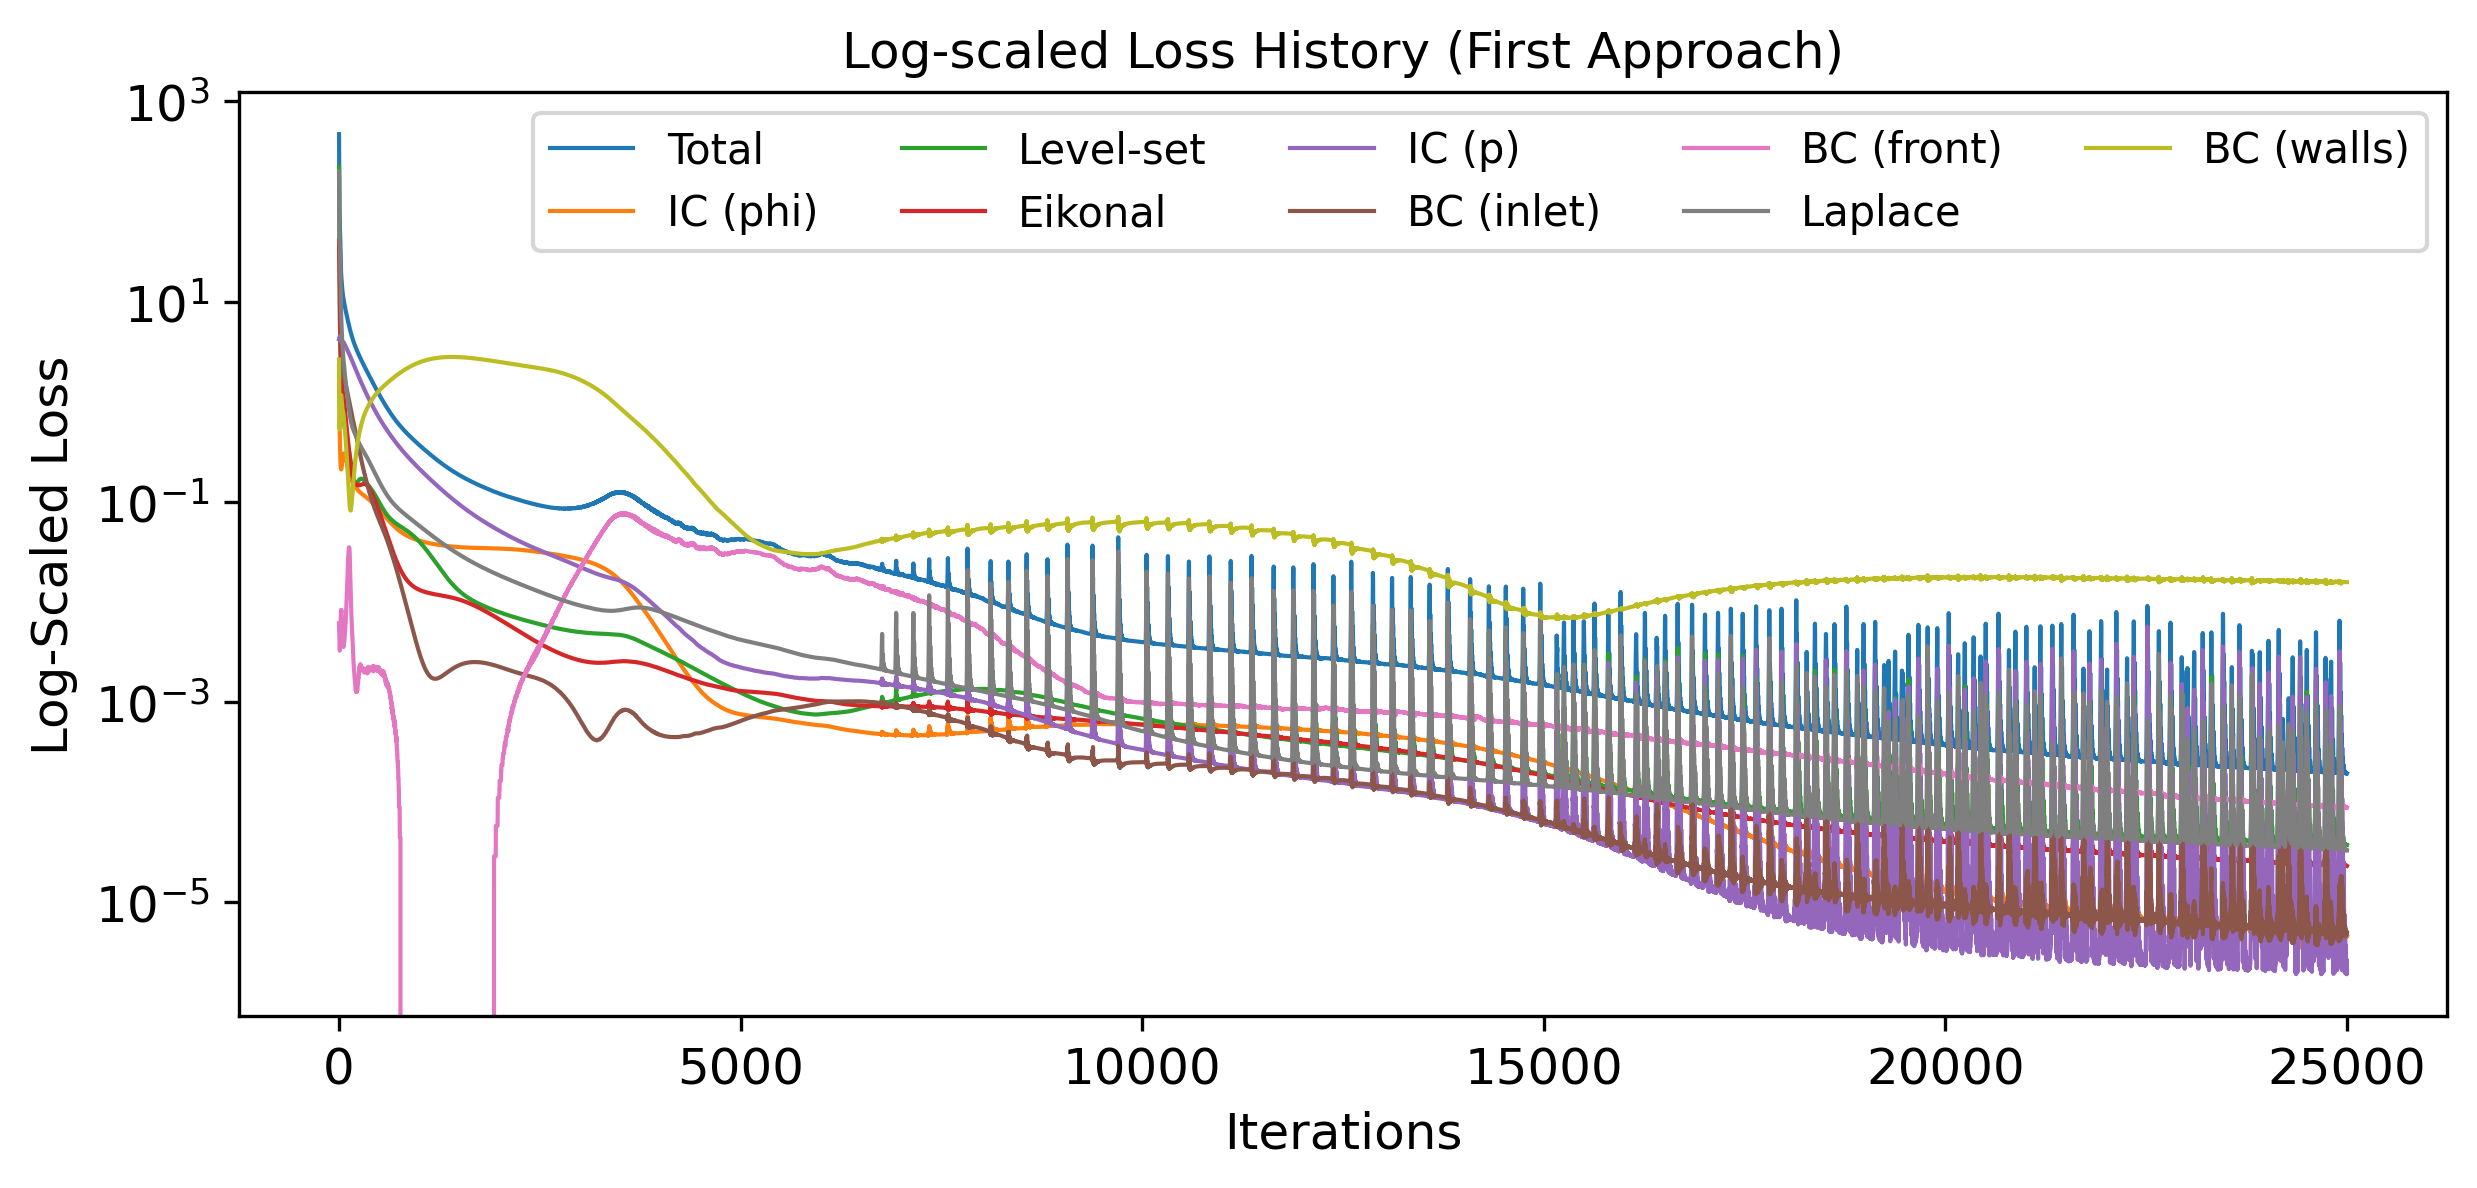

In [7]:
# Define a variable for line width
line_width = 1

# Create a plot with adjusted dimensions
fig, ax = plt.subplots(figsize=(9.5, 4))

# Plot each component of the loss with a logarithmic scale using the line width variable
ax.semilogy(loss_history['total_loss'], label='Total', linewidth=line_width)
ax.semilogy(loss_history['phi_ic_loss'], label='IC (phi)', linewidth=line_width)
ax.semilogy(loss_history['level_set_loss'], label='Level-set', linewidth=line_width)
ax.semilogy(loss_history['eikonal_loss'], label='Eikonal', linewidth=line_width)
ax.semilogy(loss_history['p_ic_loss'], label='IC (p)', linewidth=line_width)
ax.semilogy(loss_history['inlet_bc_loss'], label='BC (inlet)', linewidth=line_width)
ax.semilogy(loss_history['front_bc_loss'], label='BC (front)', linewidth=line_width)
ax.semilogy(loss_history['laplace_loss'], label='Laplace', linewidth=line_width)
ax.semilogy(loss_history['walls_bc_loss'], label='BC (walls)', linewidth=line_width)

# Setting titles and labels with appropriate size
ax.set_title('Log-scaled Loss History (First Approach)', fontsize=12)
ax.set_xlabel('Iterations')
ax.set_ylabel('Log-Scaled Loss')

# Set legend with a readable size
ax.legend(fontsize=10, ncol=5, loc='upper right')

# Save the figure with high resolution
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LAP/first_approach_training.png', bbox_inches='tight', dpi=300)
# Display the plot
plt.show()

In [4]:
pinn.load_state_dict(torch.load('./Trained Models/2D_Level_Set_Linear_Laplace_First_Approach.pth'))

<All keys matched successfully>

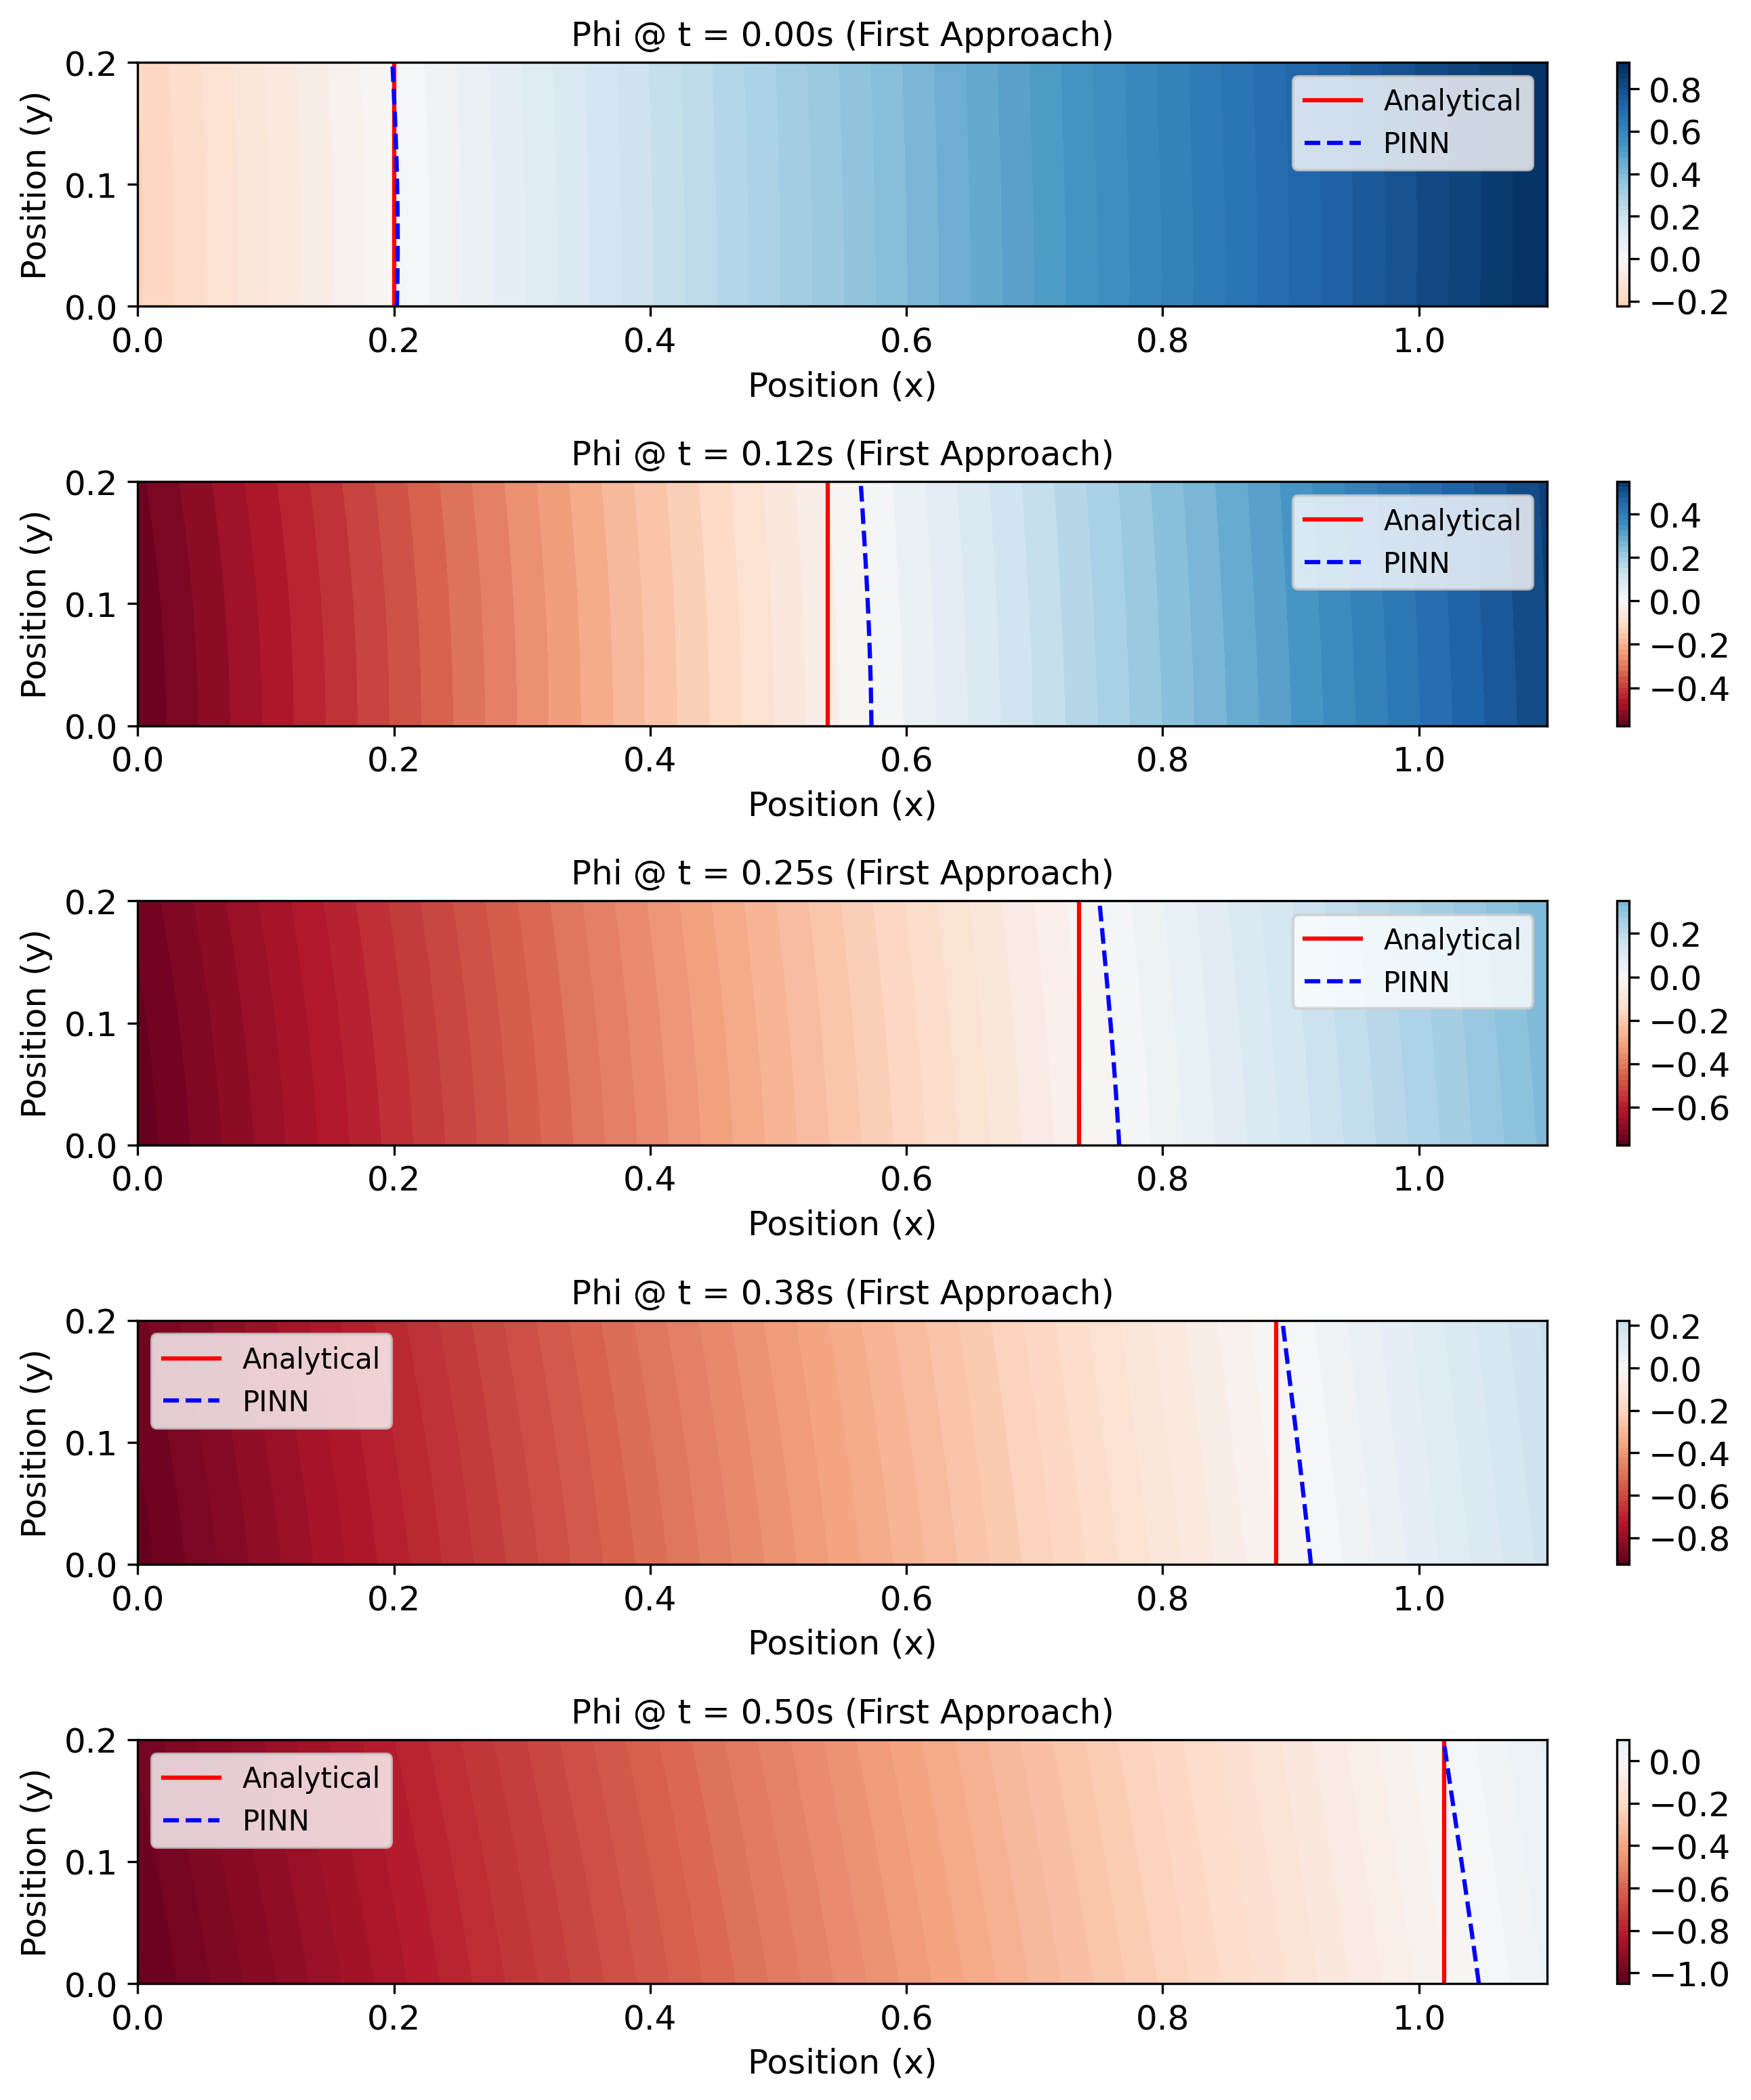

In [5]:
N_eval = 1000  # Resolution of the grid

# Generate a grid of points within the domain
x_eval = torch.linspace(0, X, N_eval).view(-1, 1)  # Space points for x
y_eval = torch.linspace(0, Y, N_eval).view(-1, 1)  # Space points for y
x_grid, y_grid = torch.meshgrid(x_eval[:, 0], y_eval[:, 0], indexing='ij')

# Analytical solution for s(t)
def s_t(t, k=1, mu=1, p_in=1, p_out=0, d=0.2):
    return np.sqrt(2 * k / mu * (p_in - p_out) * t + d**2)

# Select 6 evenly spaced time steps, including the start and end
time_steps = np.linspace(0, T, 5)

# Create a 2x3 subplot grid
fig, axs = plt.subplots(5, 1, figsize=(9.5, 10.5))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

flow_front_positions = np.zeros(N_eval)

for i, specific_time in enumerate(time_steps):
    # Flatten the grid to pass through the network
    t_eval= torch.full_like(x_grid.reshape(-1, 1), specific_time)  # Fixed time for all points
    combined_input = torch.cat([t_eval, x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)], dim=1)

    # Predict phi
    _, phi_pred = pinn(combined_input).split(1, dim=1)
    phi_pred = phi_pred.detach().numpy().reshape(N_eval, N_eval)

    # Find the maximum absolute value in phi_values for centering the colormap
    max_abs_phi = np.max(np.abs(phi_pred))

    # Contour plot of phi values in the x-y plane at the specific time
    cs = axs[i].contourf(x_grid.numpy(), y_grid.numpy(), phi_pred, 50, cmap='RdBu', vmin=-max_abs_phi, vmax=max_abs_phi)
    axs[i].axvline(x=s_t(specific_time, d=r_in), color='red', linestyle='-', label='Analytical')
    axs[i].contour(x_grid.numpy(), y_grid.numpy(), phi_pred, levels=[0], colors='b', linestyles='--')

    # Create a color bar with fewer ticks
    cbar = fig.colorbar(cs, ax=axs[i], pad=0.04)
    cbar.locator = MaxNLocator(nbins=6)  # Reduce the number of ticks
    cbar.update_ticks()

    axs[i].set_title(f'Phi @ t = {specific_time:.2f}s (First Approach)', fontsize=12)
    axs[i].set_ylabel('Position (y)')
    axs[i].set_xlabel('Position (x)')

    # Creating custom handles for the legend
    pinn_handle = mlines.Line2D([], [], color='blue', linestyle='--', label='PINN')
    analytical_handle = mlines.Line2D([], [], color='red', linestyle='-', label='Analytical')

    if i >= 3:
        axs[i].legend(handles=[analytical_handle, pinn_handle], loc='upper left', fontsize=10)
    else:
        axs[i].legend(handles=[analytical_handle, pinn_handle], fontsize=10)
plt.tight_layout()
# Display the overall title
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LAP/first_approach_phi.png', bbox_inches='tight', dpi=300)
plt.show()

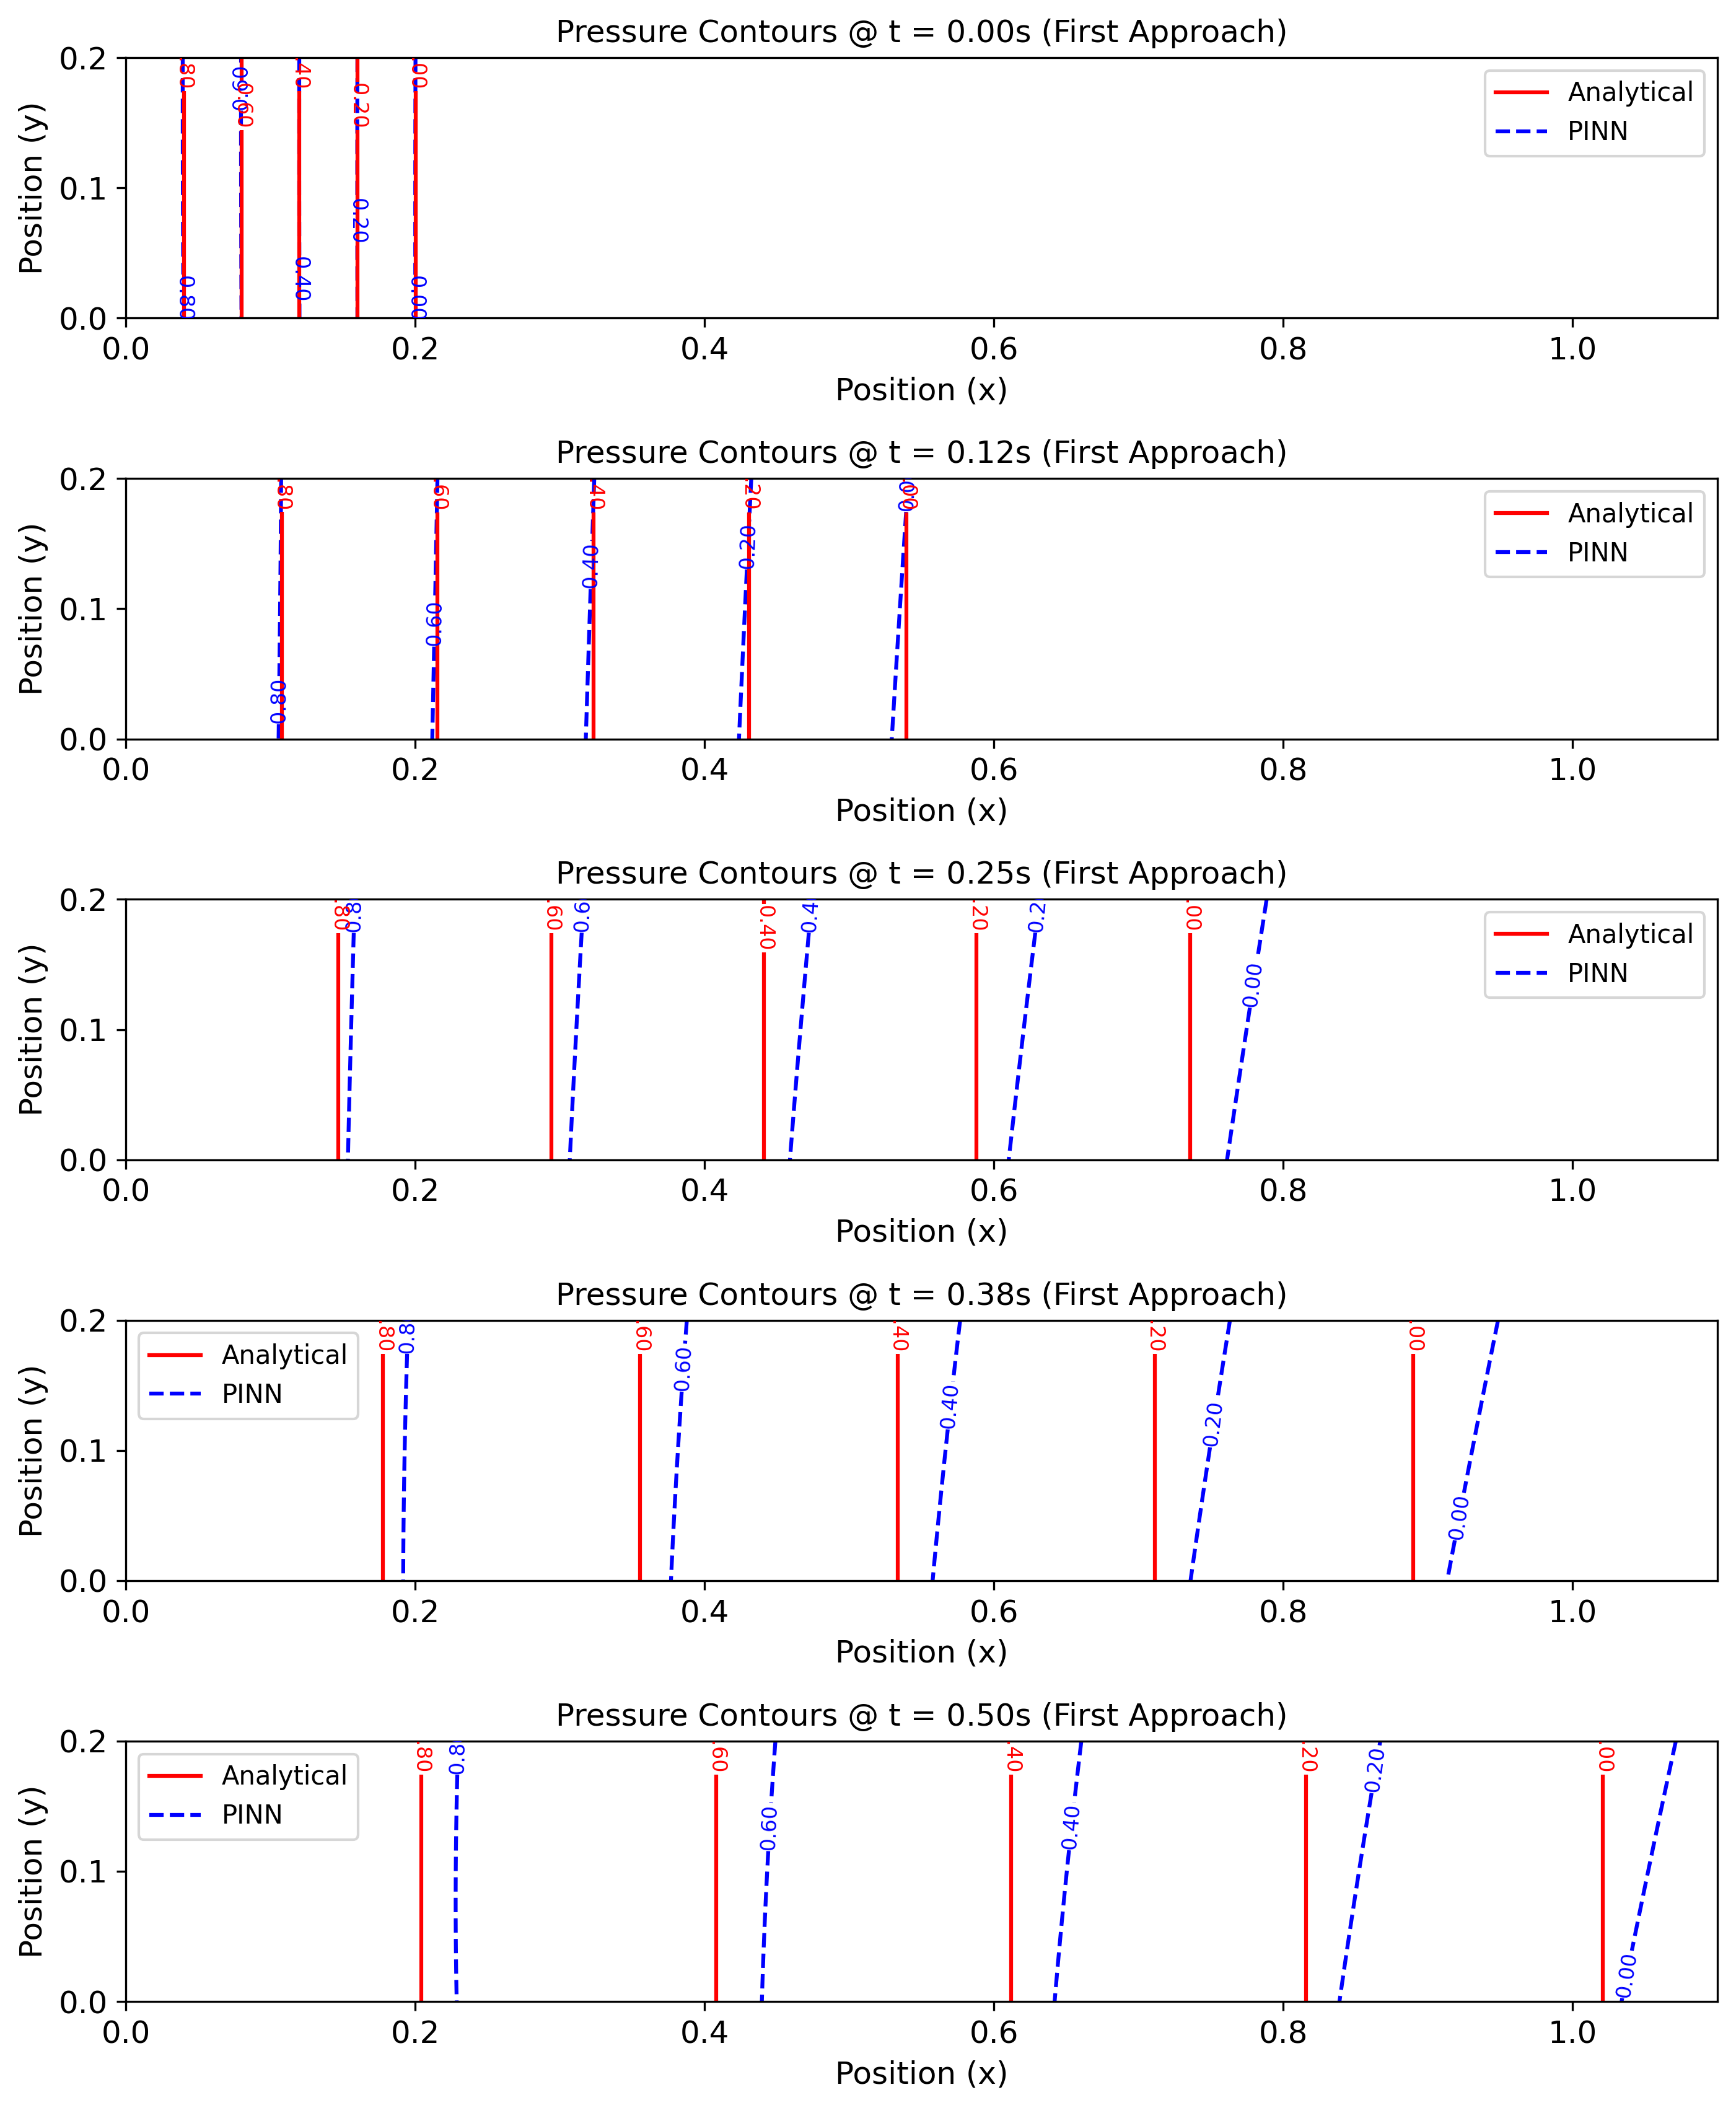

In [6]:
N_eval = 1000  # Resolution of the grid

# Generate a grid of points within the domain
x_eval = torch.linspace(0, X, N_eval).view(-1, 1)  # Space points for x
y_eval = torch.linspace(0, Y, N_eval).view(-1, 1)  # Space points for y
x_grid, y_grid = torch.meshgrid(x_eval[:, 0], y_eval[:, 0], indexing='ij')

# Select 6 evenly spaced time steps, including the start and end
time_steps = np.linspace(0, T, 5)

def analytical_pressure(x, t, p_in=1., p_out=0., k=1., mu=1., d=0.2, L=1.):
  # Calculate the current position of the flow front
  s = s_t(t, k, mu, p_in, p_out, d)
  # Pressure distribution
  pressure = np.where(x <= s,
  p_in + (p_out - p_in) * (x / s),
  p_out)
  return pressure

# Create a 2x3 subplot grid
fig, axs = plt.subplots(5, 1, figsize=(9.5, 11.5))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

for i, specific_time in enumerate(time_steps):
    # Flatten the grid to pass through the network
    t_eval= torch.full_like(x_grid.reshape(-1, 1), specific_time)  # Fixed time for all points
    combined_input = torch.cat([t_eval, x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)], dim=1)

    # Predict phi
    p_pred, phi_pred = pinn(combined_input).split(1, dim=1)
    p_pred = p_pred.detach().numpy().reshape(N_eval, N_eval)
    phi_pred = phi_pred.detach().numpy().reshape(N_eval, N_eval)

    pressures = analytical_pressure(x_grid, specific_time)

    # Contour plot of phi values in the x-y plane at the specific time
    cs = axs[i].contour(x_grid.numpy(), y_grid.numpy(), p_pred, levels=[0, 0.2, 0.4, 0.6, 0.8], colors='b', linestyles='--')
    cp = axs[i].contour(x_grid.numpy(), y_grid.numpy(), pressures, levels=[0, 0.2, 0.4, 0.6, 0.8], colors='r', linestyles='-')
    plt.clabel(cs, inline=True, fontsize=8, fmt='%1.2f')
    plt.clabel(cp, inline=True, fontsize=8, fmt='%1.2f')

    axs[i].set_title(f'Pressure Contours @ t = {specific_time:.2f}s (First Approach)', fontsize=12)
    axs[i].set_xlabel('Position (x)')
    axs[i].set_ylabel('Position (y)')
    
    # Creating custom handles for the legend
    pinn_handle = mlines.Line2D([], [], color='blue', linestyle='--', label='PINN')
    analytical_handle = mlines.Line2D([], [], color='red', linestyle='-', label='Analytical')

    if i >= 3:
        axs[i].legend(handles=[analytical_handle, pinn_handle], fontsize=10, loc='upper left')
    else:
       axs[i].legend(handles=[analytical_handle, pinn_handle], fontsize=10)

plt.tight_layout()
# Display the overall title
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LAP/first_approach_p.png', bbox_inches='tight', dpi=300)
plt.show()

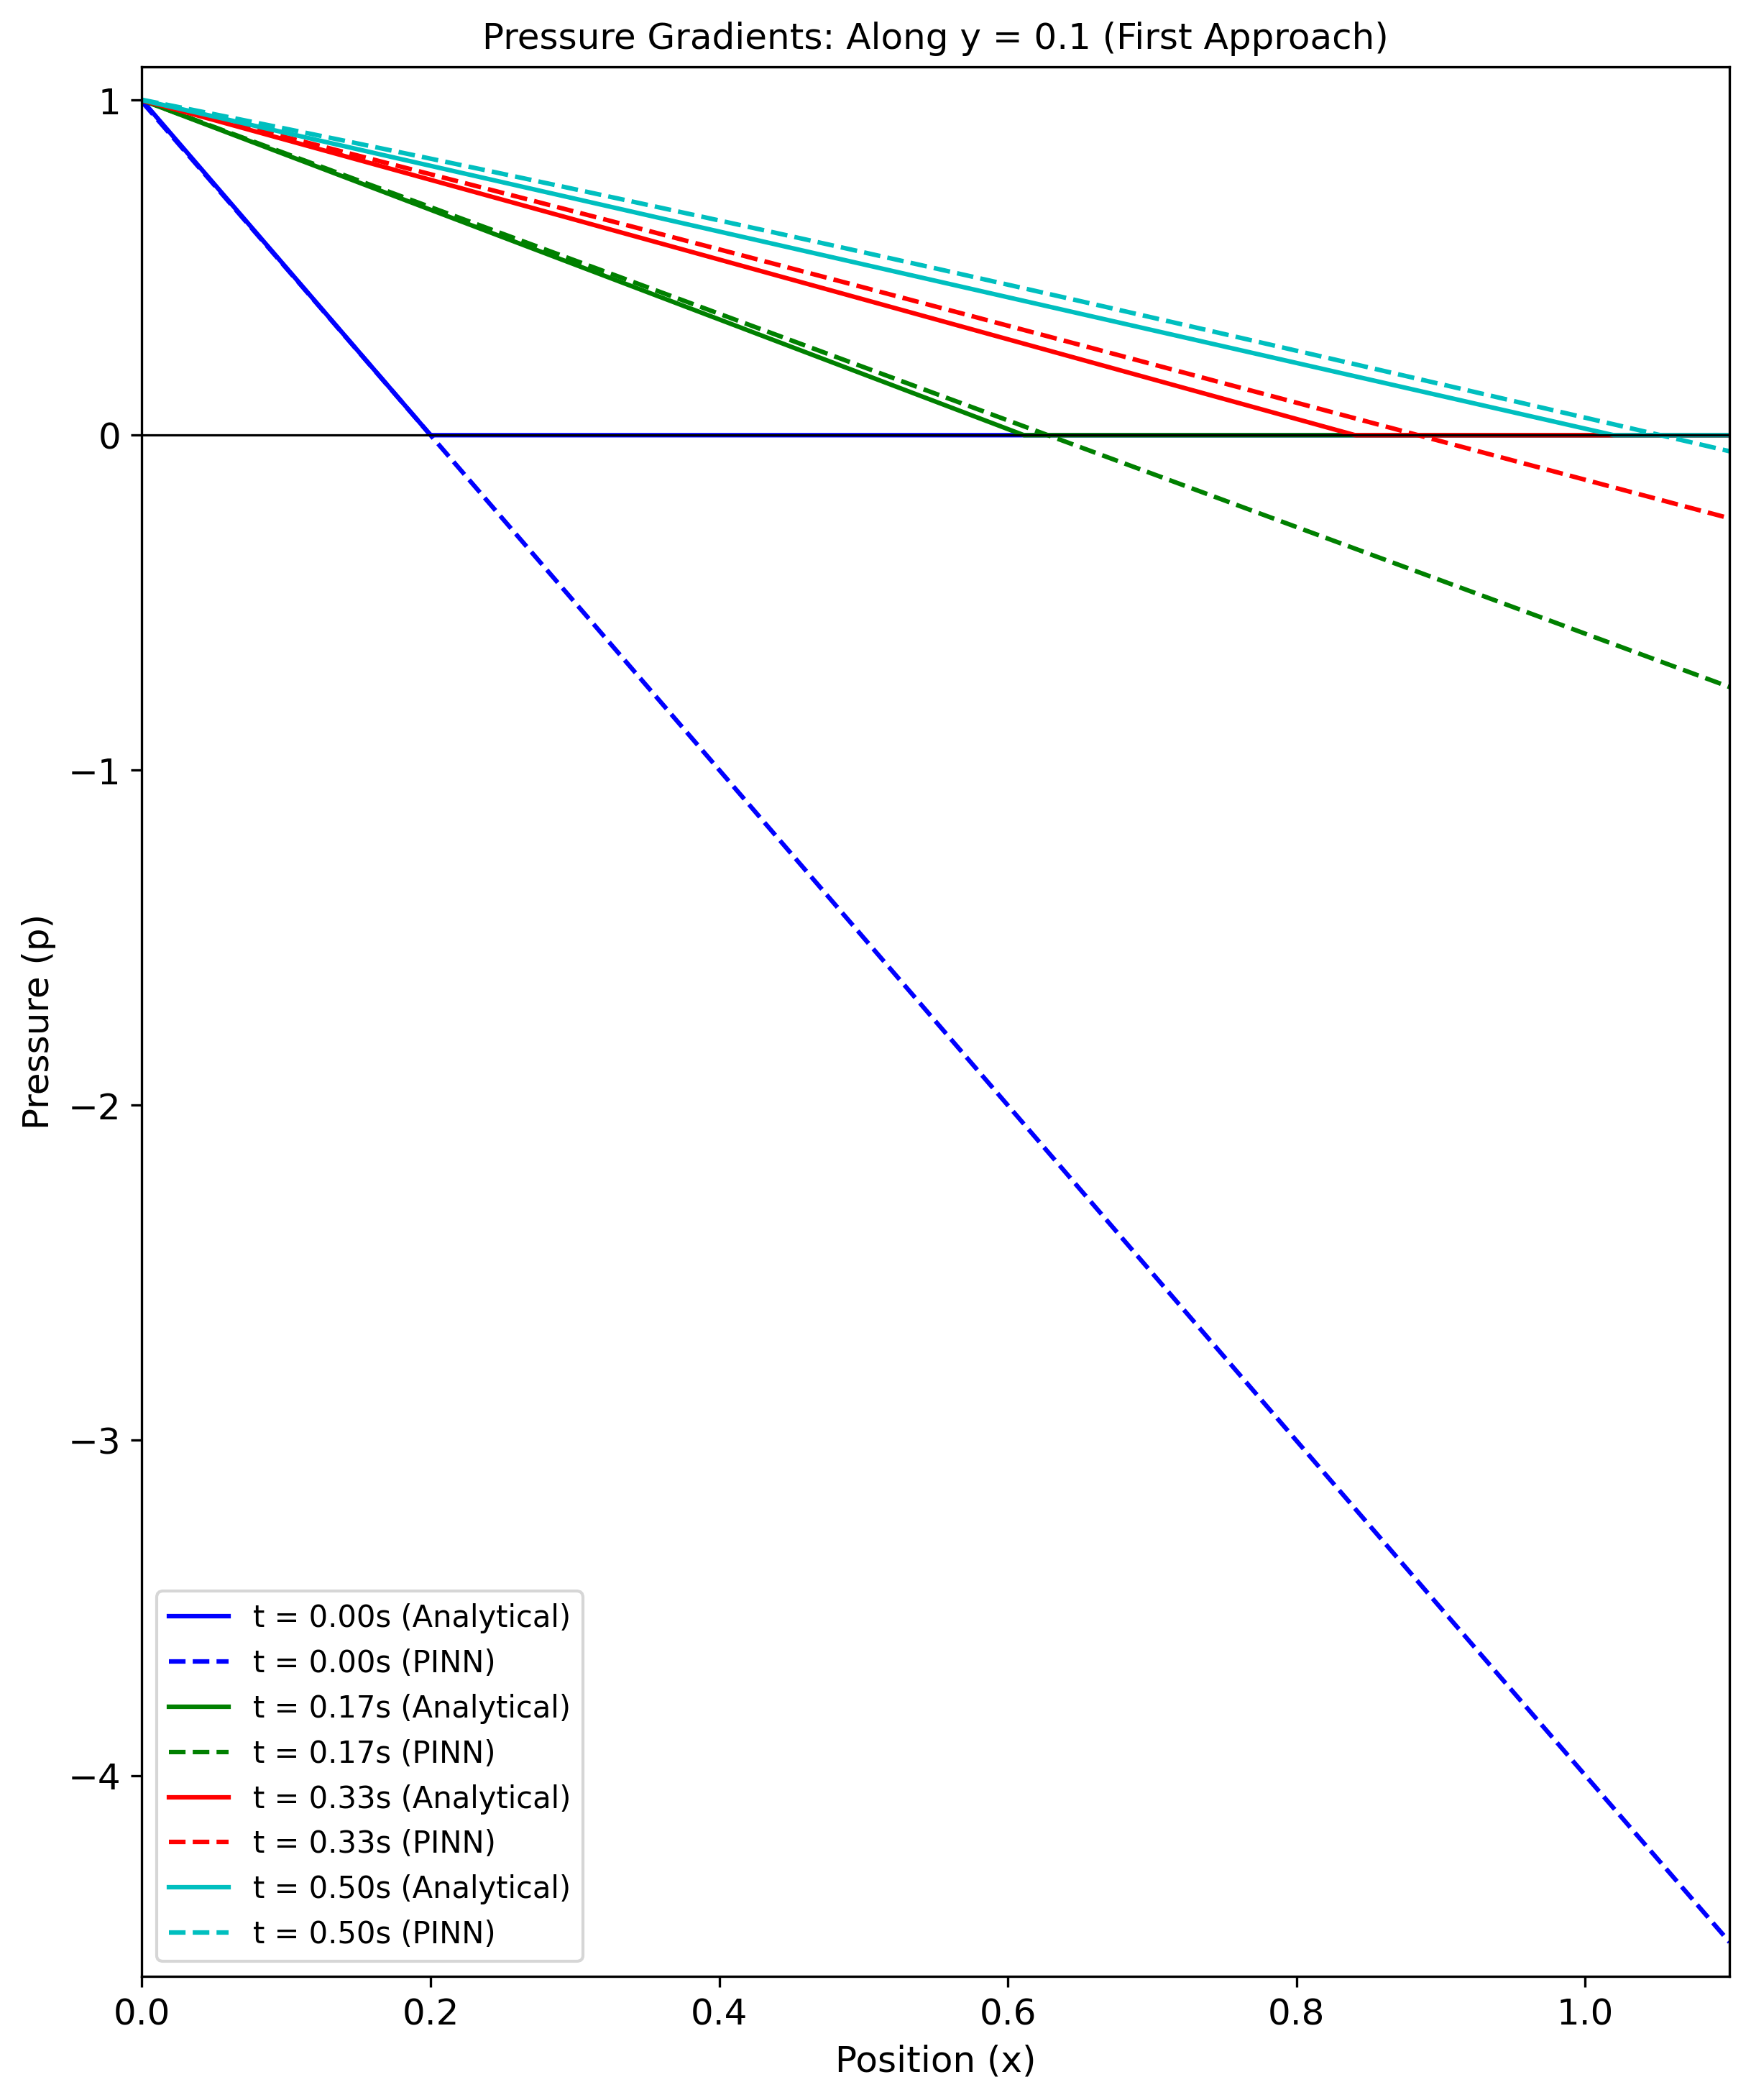

In [9]:
N_eval = 1000

x_eval = torch.linspace(0, X, N_eval).view(-1, 1)
t_eval = torch.linspace(0, T, N_eval).view(-1, 1)
y_eval = torch.full_like(x_eval, 0.1)
x, t = np.meshgrid(x_eval, t_eval)
pressure_values = np.zeros((N_eval, N_eval)) 

pressures = analytical_pressure(x, t).T

for i, t in enumerate(t_eval):
    t_repeated = t.repeat(N_eval, 1)
    combined_input = torch.cat([t_repeated, x_eval, y_eval], dim=1)
    p_pred, _ = pinn(combined_input).split(1, dim=1)
    p_pred = p_pred.detach().numpy().flatten()
    pressure_values[:, i] = p_pred
    
time_indices = [0, N_eval // 3, 2 * N_eval // 3, N_eval - 1]  # Improved distribution

colors = ['b', 'g', 'r', 'c']
labels = ['t', 't', 't', 't']

plt.figure(figsize=(9.5, 11.5))

plt.axhline(y=p_out, color='k', linewidth=0.75, linestyle='-')

for idx, color, label in zip(time_indices, colors, labels):
    plt.plot(x_eval.flatten(), pressures[:, idx], label=f'{label} = {t_eval[idx].item():.2f}s (Analytical)', color=color)
    plt.plot(x_eval.flatten(), pressure_values[:, idx], label=f'{label} = {t_eval[idx].item():.2f}s (PINN)', linestyle='--', color=color)

# Add a horizontal line at p = pout
plt.axhline(y=p_out, color='black', linewidth=0.75, linestyle='-')

plt.xlabel('Position (x)')
plt.ylabel('Pressure (p)')
plt.xlim([0, X])
plt.ylim([-4.6, 1.1])
plt.title('Pressure Gradients: Along y = 0.1 (First Approach)', fontsize=12)
plt.legend(fontsize=10)
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LAP/first_approach_pg_wall.png', bbox_inches='tight', dpi=300)
plt.show()

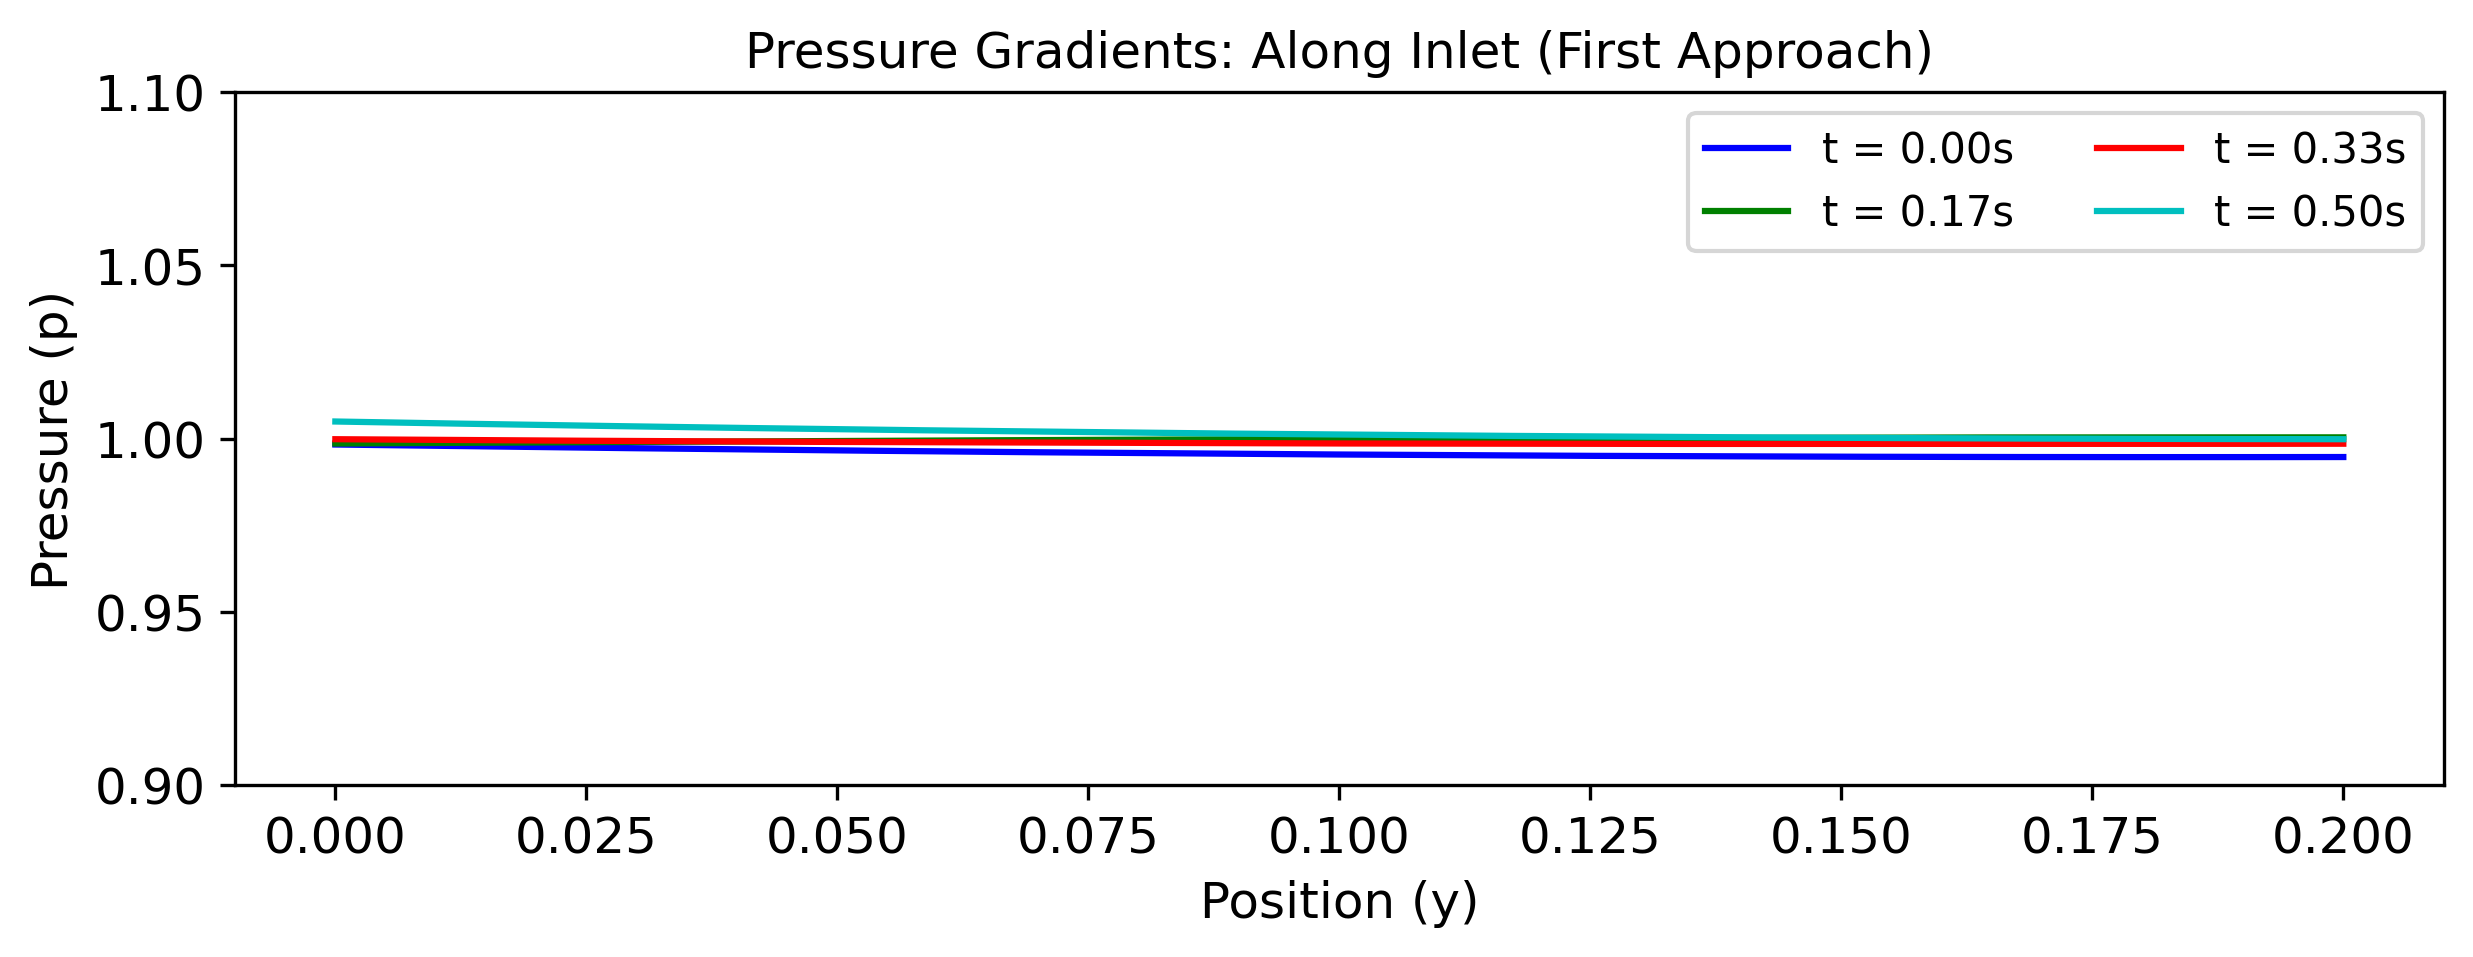

In [12]:
N_eval = 1000

y_eval = torch.linspace(0, Y, N_eval).view(-1, 1)
x_eval = torch.zeros_like(y_eval)

time_steps = np.linspace(0, T, 4)

colors = ['b', 'g', 'r', 'c']
labels = ['t', 't', 't', 't']

plt.figure(figsize=(9.5, 3))

for specific_time, color, label in zip(time_steps, colors, labels):
    t_eval = torch.full_like(x_eval, specific_time)  # Fixed time for all points

    combined_input = torch.cat([t_eval, x_eval, y_eval], dim=1)

    p_pred, phi_pred = pinn(combined_input).split(1, dim=1)

    p_pred = p_pred.detach().numpy().flatten()
    phi_pred = phi_pred.detach().numpy().flatten()

    # Plot pressure values
    plt.plot(y_eval.flatten(), p_pred, label=f'{label} = {specific_time:.2f}s', color=color)

# Add a horizontal line at p = pout
#plt.axhline(y=p_out, color='black', linewidth=0.75, linestyle='-')

plt.xlabel('Position (y)')
plt.ylabel('Pressure (p)')
plt.ylim([0.9, p_in + 0.1])
plt.title('Pressure Gradients: Along Inlet (First Approach)', fontsize=12)
plt.legend(loc='upper right', fontsize=10, ncols=2)
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LAP/first_approach_pg_inlet.png', bbox_inches='tight', dpi=300)
plt.show()